# Solving ODE MLP

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#checking if device is gpu or cpu 
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(str(device))

cpu


In [6]:
# solving equation df = R*f*(1-f)
def fx(x):
    f=1/(1+torch.exp(-x))
    return(f)

#initial condition
xB = torch.tensor([[0.0]],requires_grad=True,device=device)
fB = torch.tensor([[fx(xB)]],requires_grad=True,device=device)
R = 1.0

n_epochs = 550
batch_size = 50
lrate = 0.015
domain = (-2.,2.)
nr = 100 #number of neurons per layer

model = nn.Sequential(
    nn.Linear(1, nr),
    nn.Tanh(),
    nn.Linear(nr, nr),
    nn.Tanh(),
    nn.Linear(nr, 1))

loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=lrate)

In [7]:
#solving ode
import time
losstep = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    x = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    f = model(x)
    df = torch.autograd.grad(f.sum(), x, create_graph=True)[0]
    boundary = model(xB) - fB
    df_residual = (df - R*f*(1-f))
    loss = loss_fn(df_residual,torch.zeros_like(df_residual))+loss_fn(boundary,torch.zeros_like(boundary))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch} ({prci} %), latest loss {loss}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')

Finished epoch 54 (10 %), latest loss 0.008221143497638781
Finished epoch 109 (20 %), latest loss 0.00010753180251570063
Finished epoch 164 (30 %), latest loss 1.3093869605227106e-05
Finished epoch 219 (40 %), latest loss 9.780268638498222e-06
Finished epoch 274 (50 %), latest loss 7.05818359860369e-06
Finished epoch 329 (60 %), latest loss 5.354099613108426e-06
Finished epoch 384 (70 %), latest loss 3.3529280667500202e-06
Finished epoch 439 (80 %), latest loss 3.885724460990097e-06
Finished epoch 494 (90 %), latest loss 4.0178396848309125e-06
Finished epoch 549 (100 %), latest loss 2.6338093044029983e-06
Total time: 0.1 min


Accuracy sample points: 0.00013349237269721925


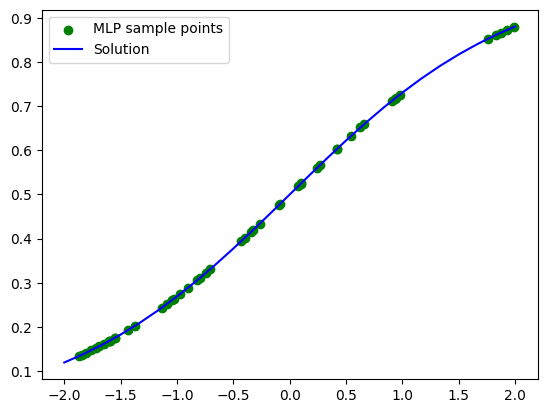

In [10]:
#verify mean difference of sample points
xt=(domain[0]-domain[1])*torch.rand(batch_size, 1,device=device)+domain[1]
yt=model(xt)
ys=fx(xt)
accuracy = (ys - yt).float().mean()
print(f'Accuracy sample points: {accuracy}')

#plot points vs solution
xs=torch.linspace(domain[0],domain[1],25,device=device)
ys=fx(xs)

xt=xt.reshape(-1,).detach().cpu().numpy()
yt=yt.reshape(-1,).detach().cpu().numpy()
xs=xs.reshape(-1,).detach().cpu().numpy()
ys=ys.reshape(-1,).detach().cpu().numpy()

plt.scatter(xt,yt,label='MLP sample points', color='g')
plt.plot(xs,ys,label='Solution',color='b')
plt.legend()
plt.show()

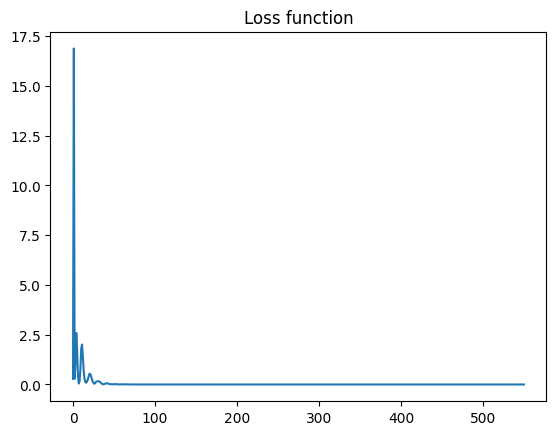

In [11]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Loss function')
plt.show()

In [56]:
#function for initial point of differential equation df = f
def fx(x):
    f=torch.exp(x)
    return(f)

xB = torch.tensor([[0.0]],requires_grad=True,device=device)
fB = torch.tensor([[fx(xB)]],requires_grad=True,device=device)

n_epochs = 550
batch_size = 50
lrate = 0.015
domain = (-2.,2.)
nr = 100 #number of neurons per layer

model1 = nn.Sequential(
    nn.Linear(1, nr),
    nn.Tanh(),
    nn.Linear(nr, nr),
    nn.Tanh(),
    nn.Linear(nr, 1))

loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model1.parameters(), lr=lrate)

In [57]:
# training model to solve ode
import time
losstep = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    x = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    f = model1(x)
    df = torch.autograd.grad(f.sum(), x, create_graph=True)[0]
    boundary = model1(xB) - fB
    df_residual = (df - f)
    loss = loss_fn(df_residual,torch.zeros_like(df_residual))+loss_fn(boundary,torch.zeros_like(boundary))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch} ({prci} %), latest loss {loss}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')

Finished epoch 54 (10 %), latest loss 0.294516551956447
Finished epoch 109 (20 %), latest loss 0.1673587384957845
Finished epoch 164 (30 %), latest loss 0.1638457671316627
Finished epoch 219 (40 %), latest loss 0.07240110640102576
Finished epoch 274 (50 %), latest loss 0.06893664698870897
Finished epoch 329 (60 %), latest loss 0.009841701129235984
Finished epoch 384 (70 %), latest loss 0.00037220366440115344
Finished epoch 439 (80 %), latest loss 0.0013017286647112644
Finished epoch 494 (90 %), latest loss 0.0023384172255296386
Finished epoch 549 (100 %), latest loss 6.434025737733583e-05
Total time: 0.1 min


Accuracy sample points: 0.0008000241359695792


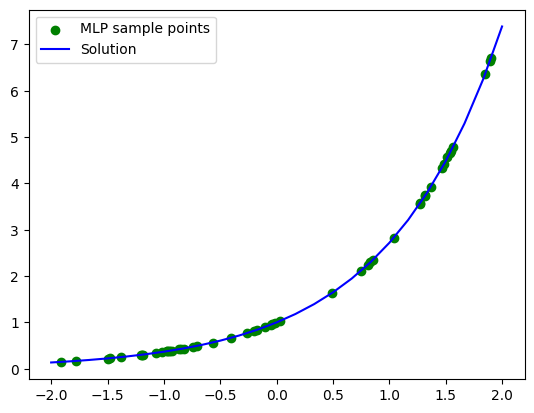

In [58]:
#verify mean difference of sample points
xt=(domain[0]-domain[1])*torch.rand(batch_size, 1,device=device)+domain[1]
yt=model1(xt)
ys=fx(xt)
accuracy = (ys - yt).float().mean()
print(f'Accuracy sample points: {accuracy}')

#plot points vs solution
xs=torch.linspace(domain[0],domain[1],25,device=device)
ys=fx(xs)

xt=xt.reshape(-1,).detach().cpu().numpy()
yt=yt.reshape(-1,).detach().cpu().numpy()
xs=xs.reshape(-1,).detach().cpu().numpy()
ys=ys.reshape(-1,).detach().cpu().numpy()

plt.scatter(xt,yt,label='MLP sample points', color='g')
plt.plot(xs,ys,label='Solution',color='b')
plt.legend()
plt.show()

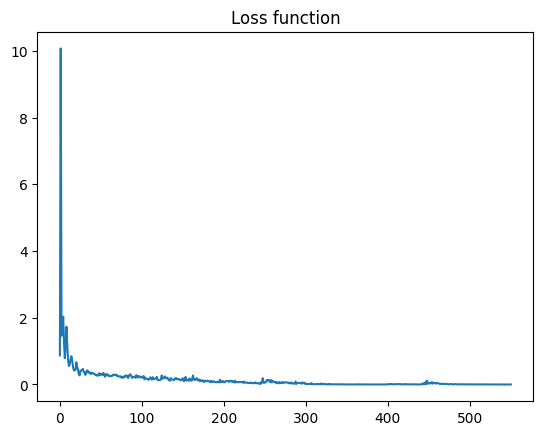

In [59]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep)
plt.title('Loss function')
plt.show()

In [63]:
# solving an exaple of linear system dx = ax + by, dy = cx + dy
def x1(t):
    xt=torch.exp(-t)
    return(xt)

def x2(t):
    xt=-2.0*torch.exp(-t)
    return(xt)

a=1.0
b=1.0
c=4.0
d=1.0

t1=torch.tensor(0.0,requires_grad=True,device=device)
vB = torch.tensor([[x1(t1),x2(t1)]],requires_grad=True,device=device)
wx=1
wy=1
wb=1

n_epochs = 4250
batch_size = 50
lrate = 0.015
nr = 300
domain = (-0.75,1.25)
sample_size=batch_size

modelsys = nn.Sequential(
    nn.Linear(1, nr),
    nn.Tanh(),
    nn.Linear(nr, nr),
    nn.Tanh(),
    nn.Linear(nr, 2))

loss_fn = nn.MSELoss()  
optimizer = optim.Adam(modelsys.parameters(), lr=lrate)

In [64]:
import time
losstep = []
lossxl = []
lossyl = []
start=time.time()
c0=0
for epoch in range(n_epochs):
    t = (domain[0]-domain[1])*torch.rand(batch_size, 1,requires_grad=True,device=device)+domain[1]
    v = modelsys(t)

    x = v[:,0].reshape(batch_size,1)
    y = v[:,1].reshape(batch_size,1)
    dx = torch.autograd.grad(x.sum(), t, create_graph=True)[0]
    dy = torch.autograd.grad(y.sum(), t, create_graph=True)[0]
    #dv = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    
    dx_residual = a*x + b*y - dx
    dy_residual = c*x + d*y - dy
    #dv_residual = a*x + b*y + c*x + d*y - dv
    bd = modelsys(torch.tensor([[t1]],requires_grad=True)) - vB
    
    lossx =loss_fn(dx_residual,torch.zeros_like(dx_residual))
    lossy =loss_fn(dy_residual,torch.zeros_like(dy_residual))
    loss = (wx*lossx + wy*lossy + wb*loss_fn(bd,torch.zeros_like(bd)))
    #loss = loss_fn(dv_residual,torch.zeros_like(dv_residual))+loss_fn(bd,torch.zeros_like(bd))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losstep.append(loss.detach().cpu().numpy())
    lossxl.append(lossx.detach().cpu().numpy())
    lossyl.append(lossy.detach().cpu().numpy())
    c0=c0+1
    prct = c0/n_epochs
    if prct >= .10:
        prci=round((epoch/n_epochs)*100)
        print(f'Finished epoch {epoch}, ({prci}%), latest loss {loss}, x_loss: {lossx}, y_loss: {lossy}')
        c0=0
end=time.time()
time0=round((end-start)/60,1)
print(f'Total time: {time0} min')

Finished epoch 424, (10%), latest loss 0.09819651436556318, x_loss: 0.0368441978635392, y_loss: 0.052828525942402164
Finished epoch 849, (20%), latest loss 0.6365092461177257, x_loss: 0.05099148151654722, y_loss: 0.5673123783242852
Finished epoch 1274, (30%), latest loss 2.5000470693108037, x_loss: 0.2804780761030486, y_loss: 2.1117887235758768
Finished epoch 1699, (40%), latest loss 0.2752371215499289, x_loss: 0.022481672786216975, y_loss: 0.24732159972830664
Finished epoch 2124, (50%), latest loss 0.08711154822305958, x_loss: 0.008124231888772237, y_loss: 0.07828605281136279
Finished epoch 2549, (60%), latest loss 0.017122232624979722, x_loss: 0.001126682874509465, y_loss: 0.015531789123679373
Finished epoch 2974, (70%), latest loss 0.5462908177665965, x_loss: 0.03979750092034738, y_loss: 0.4929170601337799
Finished epoch 3399, (80%), latest loss 0.009222716935475071, x_loss: 0.0033083918392629195, y_loss: 0.005500440923896115
Finished epoch 3824, (90%), latest loss 0.011656622229664

Accuracy x1 sample points: 0.0014838561182841659, Accuracy x2 sample points: -0.006667265668511391


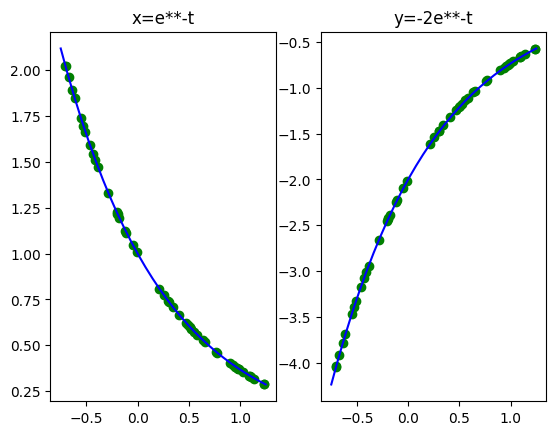

In [65]:
#verify mean difference of sample points
ti=(domain[0]-domain[1])*torch.rand(sample_size, 1,device=device)+domain[1]
vi=modelsys(ti)
xi=vi[:,0].reshape(sample_size,1)
yi=vi[:,1].reshape(sample_size,1)
x1s=x1(ti)
x2s=x2(ti)
acc1 = (x1s - xi).float().mean()
acc2 = (x2s - yi).float().mean()
print(f'Accuracy x1 sample points: {acc1}, Accuracy x2 sample points: {acc2}')

xi=xi.reshape(sample_size,1).detach().cpu().numpy()
yi=yi.reshape(sample_size,1).detach().cpu().numpy()
ti=ti.reshape(sample_size,1).detach().cpu().numpy()
ts=torch.linspace(domain[0],domain[1],30)

figure, axis = plt.subplots(1, 2)
axis[0].scatter(ti,xi,color='g')
axis[0].plot(ts.detach().cpu().numpy(),x1(ts).detach().cpu().numpy(),color='b')
axis[0].set_title('x=e**-t')
axis[1].scatter(ti,yi,color='g')
axis[1].plot(ts.detach().cpu().numpy(),x2(ts).detach().cpu().numpy(),color='b')
axis[1].set_title('y=-2e**-t')
plt.show()

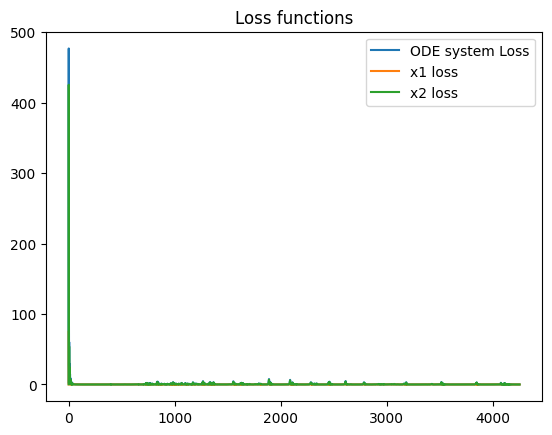

In [67]:
plt.plot(np.linspace(0,n_epochs,n_epochs),losstep,label='ODE system Loss')
plt.plot(np.linspace(0,n_epochs,n_epochs),lossxl,label='x1 loss')
plt.plot(np.linspace(0,n_epochs,n_epochs),lossyl,label='x2 loss')
plt.title('Loss functions')
plt.legend()
plt.show()